In [20]:
import gpxpy
from pathlib import Path
import requests
import json
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from unit_convert import UnitConvert
import time
import numpy as np
import matplotlib.cm as cm
from matplotlib.pyplot import figure, show, rc

coordinate_info_dict = {}
polyline_dict = {}
lat_lon_sampled_dict = {}
lat_lon_el_dict = {}
df_dict = {}

ski_lines_file = Path(r'C:\Users\JonBanks\Documents\Skiing\run_list\Ski_Lines.json')

In [15]:
aspect_dict = {'N':0,
     'NNE':22.5,
     'NE':45,
     'ENE':67.5,
     'E':90,
     'ESE':112.5,
     'SE':135,
     'SSE':157.5,
     'S':180,
     'SSW':202.5,
     'SW':225,
     'WSW':247.5,
     'W':270,
     'WNW':292.5,
     'NW':315,
     'NNW':337.5}

In [16]:
def human_aspect(deg):
    
    for aspect,aspect_deg in aspect_dict.items():
        if abs(deg-aspect_deg) < 22.5:
            final_aspect = aspect
            return final_aspect

print(human_aspect(315))

def lle_to_xyz(lat,lon,el):

    cosLat = math.cos(lat * math.pi / 180.0);
    sinLat = math.sin(lat * math.pi / 180.0);
    cosLon = math.cos(lon * math.pi / 180.0);
    sinLon = math.sin(lon * math.pi / 180.0);
    rad = 6378137.0;
    f = 1.0 / 298.257224;
    C = 1.0 / math.sqrt(cosLat * cosLat + (1 - f) * (1 - f) * sinLat * sinLat);
    S = (1.0 - f) * (1.0 - f) * C;
    # el = 0.0;
    current_x = (rad * C + el) * cosLat * cosLon;
    current_y = (rad * C + el) * cosLat * sinLon;
    current_z = (rad * S + el) * sinLat;
    return current_x, current_y, current_z

NW


In [17]:
for title, df in df_dict.items():
    print(title,df['aspect'].mean())

# Do Everything

In [18]:
############# Get Data from Caltopo JSON

ski_lines_file = Path(r'C:\Users\JonBanks\Documents\Skiing\run_list\Ski_Lines.json')
# run_name = 'Banana Bowl'


with open(ski_lines_file) as f:
    data = json.load(f)

## Generate Run List:
run_list = []
for line in data['features']:
    run_list.append(line['properties']['title'])
run_list.sort()
for run in run_list:
    print(run)


AIARE Day 2 Line
Aspen
Audobahn Cradle
Baldys Skirt
Banana Bowl
Battle Bushes
Battle Shoulder
Beacon S Face
Caribou Glades
Caribou Hill
Caribou Trees
Curvaceous Couloir
Dragontail Apron
Dream Chute 1
Dream Chute 2
Easy Alley
Flattop north face
Frost Mountain Ascent
Grays east face
Haiyaha Shortcut
Joe Mills
LP N. Shorty
Lefthand Glades
Little Pawnee Ascent
Little Pawnee East Buttress
Little Pawnee East Shoulder
Little Pawnee South Shoulder
Long Lake Meadows
Mario Gully
McMillan West Ridge
Meadow Mountain
Meeker Shoulder
Mooswa 
Mt Toll South East Face
Mt Wuh
Niwot Mystery Road
Niwot Ramp
No Go - 12/4/2024
No go
Nogo 2
Otis Chute
Paiute South Slope
Pawnee SE Slope
Pawshoni Bowl
Pawshoni keyhole
Powerline 
Quandary
Sheltered Trees
Sneak-a-bahn 
St Vrain South Face
St Vrain Trees
Terrain Park
Test
The Office
Tincan 
Tuning Fork
Tyndall Gorge
US Basin
Upper Hidden Valley Right
WGK North Gully


In [25]:
sleep_period = 1.1
for run_name in run_list:
    print()
    time.sleep(sleep_period)
    ######## Find Run Name
    index = 0
    found = False
    for i, group in enumerate(data['features']):
        if group['properties']['title'] == run_name:
            index = i
            found = True
    if found == True:
        ski_line = data['features'][index]
        if ski_line['geometry'] == None:
            continue
        title = ski_line['properties']['title']
        # polyline = ski_line['geometry']['coordinates']
        polyline_dict[title] = ski_line['geometry']['coordinates']
        # print(title)
        # print(polyline_dict[title])
    else:
        raise ValueError(f'{run_name} not found')



    ############## Sub Sampling
    
    resolution = 0.00013
    total_dist = 0
    while True:
        lat_lon_sampled = []

        print(" Calculating Resolution...")
        for i, (lon,lat) in enumerate(polyline_dict[title]):
            if i > 0:
                total_dist += math.sqrt(((lat - last_lat))**2 + ((lon - last_lon))**2)
                # print('lon',lon,last_lon)
                # print('lat',lat,last_lat)
                # print('total',total_dist)
            last_lat = lat
            last_lon = lon
        resolution = total_dist/99

        print('Sub sampling...')
        for i, (lon,lat) in enumerate(polyline_dict[title]):
            if i > 0:
                dist_lat = (lat - last_lat)
                dist_lon = (lon - last_lon)
                dist = math.sqrt((dist_lat)**2 + (dist_lon)**2)
                # print('dist',dist)
                num_samples = int(dist/resolution)
                # num_samples = int((99 - len(polyline_dict[title]))/(len(polyline_dict[title])-1))
                # num_samples = 10
                # print("num",num_samples)
                for i in range(1,num_samples+1):
                    new_lat = last_lat + i*dist_lat/num_samples
                    new_lon = last_lon + i*dist_lon/num_samples
                    lat_lon_sampled.append((new_lat,new_lon))
            else:
                lat_lon_sampled.append((lat,lon))

                
            last_lat = lat
            last_lon = lon
            # return lat_lon_sampled
        total_coords = len(lat_lon_sampled)
        if total_coords > 100:
            recommended_resolution = round((resolution * len(lat_lon_sampled))/99+.00001,5)
            print(f'  Too many coordinates for API request ({total_coords}). Increasing resolution to {recommended_resolution}')
            resolution = recommended_resolution
        else:
            break
    lat_lon_sampled_dict[title] = lat_lon_sampled
    lat_lon_sampled_dict[title] 

    print(f'Completed Sub-sampling: {lat_lon_sampled}')

    ################## Get Elevations from API

    ### Api Guidelines
    # Max 100 locations per request.
    #     Multiple locations separated by pipe: https://api.opentopodata.org/v1/ned10m?locations=40.052716203284724,-105.564923286438|40.05199350679047,-105.55801391601564|40.04680300682545,-105.54962396621706
    # Max 1 call per second.
    #     Use a sleep period when looping of 1s
    # Max 1000 calls per day.d

    request_string = f'https://api.opentopodata.org/v1/ned10m?locations='
    for (lat,lon) in lat_lon_sampled:
        if request_string[-1]!= '=':
            request_string += '|'
        request_string +=f'{lat},{lon}'
    # coordinate_info = requests.get(request_string).json()
    if title not in coordinate_info_dict.keys():
        print(f'Requesting elevation for {title}')
        coordinate_info_dict[title] = requests.get(request_string).json()
        sleep_period = 1.1
    else:
        print(f'Already have elevation for {title}')
        sleep_period = 0
    coordinate_info_dict[title]

    ################### Put Elevation into a list
    lat_lon_el = []
    for coord_dict in coordinate_info_dict[title]['results']:
        elevation_m = coord_dict['elevation']
        elevation_ft = UnitConvert(meters=elevation_m)['ft']
        # print(elevation_ft)
        lat = coord_dict['location']['lat']
        lon = coord_dict['location']['lng']
        lat_lon_el.append((lat,lon,elevation_m))
        # return lat_lon_el
    lat_lon_el_dict[title] = lat_lon_el
    # print(lat_lon_el_dict[title])

    ################### Calculate Slope Angle
    x_list = []
    y_list = []
    z_list = []
    v_list = []

    df_dict[title] = pd.DataFrame(columns = ['lat_distance','lon_distance','x_distance','el','slope_angle','aspect'])
    x_distance = 0
    lat_distance = 0
    lon_distance = 0
    for i, (lat,lon,el) in enumerate(lat_lon_el):
        # print('(Lat,Lon,El)',(lat,lon,el))
        current_x, current_y, current_z = lle_to_xyz(lat,lon,el)
        x_list.append(current_x)
        y_list.append(current_y)
        z_list.append(current_z)
        coord = (current_x,current_y,current_z)
        # print(' Coord:',coord)
        if i > 0:
            vector = (current_x - last_x, current_y - last_y, current_z - last_z)
            # print(' Vector:',vector)
            distance = np.linalg.norm(vector)
            # print(' Distance:',distance)
            elevation_gain = el - last_el
            # print(' Elevation Gain:', elevation_gain)
            slope_angle = math.asin(abs(elevation_gain)/distance)*180/math.pi
            # print(' Slope Angle:',slope_angle)
            x_diff = distance*math.cos(slope_angle*math.pi/180)
            x_distance += x_diff

            
        else:
            slope_angle = 0
            aspect = 0
        
        ### Calculate Aspect
        if i > 0:
            vector_lon = lon - last_lon
            vector_lat = lat - last_lat

            aspect = math.atan2(vector_lon,vector_lat)*180/math.pi
            if aspect < 0:
                aspect = 360+aspect
            # aspect_list.append(aspect)
            lat_distance += x_diff*math.cos(aspect*math.pi/180)
            lon_distance += x_diff*math.sin(aspect*math.pi/180)
        
        
        df_dict[title].loc[len(df_dict[title])] = [lat_distance,lon_distance,x_distance,el,slope_angle,aspect]
        # print()

        last_x = current_x
        last_y = current_y
        last_z = current_z
        last_el = el
        last_lon = lon
        last_lat = lat

        
        
    # df_dict[title].loc[0]['slope_angle'] = df_dict[title].loc[1]['slope_angle']
    df_dict[title].loc['slope_angle',0] = df_dict[title].loc[1]['slope_angle']
    # df_dict[title].loc[0]['aspect'] = df_dict[title].loc[1]['aspect']
    df_dict[title].loc['aspect',0] = df_dict[title].loc[1]['aspect']
    df_dict[title]['cardinal'] = df_dict[title]['aspect'].apply(human_aspect)

    # fig, ax = plt.subplots()
    # fig.suptitle(title)
    # df_dict[title].plot.scatter(x = 'x_distance', y = 'el', c = 'slope_angle', cmap = 'coolwarm', ax = ax)


 Calculating Resolution...
Sub sampling...
Completed Sub-sampling: [(39.90012207882282, -105.67238230961544), (39.90010624074544, -105.67238906939727), (39.900090402668056, -105.6723958291791), (39.900074564590675, -105.67240258896092), (39.90005872651329, -105.67240934874275), (39.90004288843591, -105.67241610852457), (39.90002705035854, -105.6724228683064), (39.90001121228116, -105.67242962808822), (39.899995374203776, -105.67243638787005), (39.899979536126395, -105.67244314765188), (39.899963698049014, -105.6724499074337), (39.89994785997163, -105.67245666721553), (39.89993202189425, -105.67246342699735), (39.89991618381687, -105.6724701867792), (39.89990034573949, -105.67247694656102), (39.89988450766211, -105.67248370634285), (39.89986866958473, -105.67249046612467), (39.89985283150735, -105.6724972259065), (39.89983699342997, -105.67250398568832), (39.89982115535259, -105.67251074547015), (39.89980531727521, -105.67251750525197), (39.89978947919783, -105.6725242650338), (39.8997

In [23]:
import plotly.express as px
import plotly.io as pio
import plotly.io as pio
pio.renderers.default = "vscode"

# df = px.data.wind()
# df = df_dict['Audobahn Cradle']
cardinal_df = pd.DataFrame(columns = ['cardinal','count'])
for direction in aspect_dict.keys():
    count = df_dict['Mt Toll South East Face']['cardinal'].value_counts().get(direction,0)
    cardinal_df.loc[len(cardinal_df)] = [direction,count]
# fig = px.bar_polar(df, r="frequency", theta="direction",
#                    color="strength", template="plotly_dark",
#                    color_discrete_sequence= px.colors.sequential.Plasma_r)
fig = px.bar_polar(cardinal_df, r="count", theta="cardinal",template="plotly_dark",
                   color = 'cardinal',
                   color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.show()

In [27]:
def get_x(aspect):
    x = math.cos(aspect*math.pi/180)
    # y = math.sin(aspect*math.pi/180)
    return x
def get_y(aspect):
    x = math.cos(aspect*math.pi/180)
    y = math.sin(aspect*math.pi/180)
    return y

def get_average_aspect(df):
    df['aspect_x'] = df['aspect'].apply(get_x)
    df['aspect_y'] = df['aspect'].apply(get_y)

    average_aspect = math.atan2(df['aspect_y'].mean(),df['aspect_x'].mean())*180/math.pi
    if average_aspect < 0:
        average_aspect = 360+average_aspect
    average_human_aspect = human_aspect(average_aspect)
    return average_human_aspect

def get_ft_above_max_slope(df,max_slope):
    # df = df_dict['Mt Toll South East Face']
    df['drop'] = df['el_ft'].diff()
    filt = df['slope_angle'] > max_slope
    return round(-df[filt]['drop'].sum())

def get_ft_below_treeline(df,treeline,near_treeline_delta):
    df['drop'] = df['el_ft'].diff()
    filt = df['el_ft'] < treeline - near_treeline_delta
    return round(abs(-df[filt]['drop'].sum()))

def get_ft_near_treeline(df,treeline,near_treeline_delta):
    df['drop'] = df['el_ft'].diff()
    filt = (df['el_ft'] >= treeline - near_treeline_delta) & (df['el_ft'] < treeline + near_treeline_delta)
    return round(abs(-df[filt]['drop'].sum()))

def get_ft_above_treeline(df,treeline,near_treeline_delta):
    df['drop'] = df['el_ft'].diff()
    filt = df['el_ft'] >= treeline + near_treeline_delta
    return round(abs(-df[filt]['drop'].sum()))

def get_tree_cover(el):
    if el < treeline - near_treeline_delta:
        return 'BTL'
    elif (el >= treeline - near_treeline_delta) and (el < treeline + near_treeline_delta):
        return 'NTL'
    else:
        return 'ATL'

def nogo_filter(df,hazard_zone,max_slope):
    filtered_df = pd.DataFrame(columns = list(df.columns))
    for aspect, disallowed_treecover in hazard_zone.items():
        new_df = df[((df['cardinal'].isin([aspect])) & (df['slope_angle'] > max_slope)) & (df['tree_cover'].isin(disallowed_treecover))]
        if len(new_df) > 0:
            filtered_df = pd.concat([filtered_df,new_df])
    return filtered_df


In [28]:
df_dict[title]

,lat_distance,lon_distance,x_distance,el,slope_angle,aspect,0,cardinal
0,0.000000,0.000000,0.000000,3084.770996,0.000000,0.000000,NaN,N
1,3.299525,4.775708,5.804675,3082.827637,18.510139,55.359495,NaN,NE
2,6.599049,9.551413,11.609347,3081.059814,16.938200,55.359495,NaN,NE
3,9.898571,14.327115,17.414015,3079.614258,13.984110,55.359495,NaN,NE
4,13.198091,19.102815,23.218681,3078.356689,12.224093,55.359495,NaN,NE
...,...,...,...,...,...,...,...,...
92,271.849899,446.710471,540.514654,2935.928467,20.338072,80.381029,NaN,ENE
93,272.728379,451.893918,545.772016,2933.784668,22.184203,80.381029,NaN,ENE
94,273.606858,457.077363,551.029375,2931.656982,22.033482,80.381029,NaN,ENE
slope_angle,NaN,NaN,NaN,NaN,NaN,NaN,18.510139,None


In [29]:
title = 'Little Pawnee South Shoulder'
df_dict[title]['tree_cover'] = df_dict[title]['el_ft'].apply(get_tree_cover)
tree_cover_df = pd.DataFrame(columns = ['tree_cover','count'])
tree_cover_dict = {}
for tree_cover in ['ATL','NTL','BTL']:
    count = df_dict[title]['tree_cover'].value_counts().get(tree_cover,0)
    tree_cover_df.loc[len(tree_cover_df)] = [tree_cover,count]
    tree_cover_dict[tree_cover] = count
df_dict[title]['tree_cover'].value_counts()
str(tree_cover_dict)



KeyError: 'el_ft'

In [30]:
### Run Summary List
max_slope = 30
treeline = 11750
near_treeline_delta = 400

hazard_zone = {'N':['BTL','NTL','ATL'],
            'NNW':['BTL','NTL','ATL'],
            'NW':['BTL','NTL','ATL'],
            'WNW':[],
            'W':[],
            'WSW':[],
            'SW':[],
            'SSW':[],
            'S':[],
            'SSE':[],
            'SE':['NTL','ATL'],
            'ESE':['BTL','NTL','ATL'],
            'E':['BTL','NTL','ATL'],
            'ENE':['BTL','NTL','ATL'],
            'NE':['BTL','NTL','ATL'],
            'NNE':['BTL','NTL','ATL']}

# BTL NTL ATL
# N,

terrain_to_avoid = [()]
summary_df = pd.DataFrame(columns = ['title','aspect','max_angle','ft_above_max_slope','ft_btl','ft_ntl','ft_atl','ft_nogo'])
for title, df in df_dict.items():
    max_angle = math.ceil(df['slope_angle'].max())
    aspect = get_average_aspect(df)
    
    df['el_ft'] = df['el'] * 3.28084
    # Simple max slope angle flaggin:
    ft_above_max_slope = get_ft_above_max_slope(df,max_slope)

    # Determining how much of the line is in each elevation level
    ft_btl = get_ft_below_treeline(df,treeline,near_treeline_delta)
    ft_ntl = get_ft_near_treeline(df,treeline,near_treeline_delta)
    ft_atl = get_ft_above_treeline(df,treeline,near_treeline_delta)
    df['tree_cover'] = df['el_ft'].apply(get_tree_cover)

    #### No Go Zone
    filtered_df = nogo_filter(df,hazard_zone,max_slope)
    ft_nogo = round(-filtered_df['drop'].sum())
    ###############





    
    summary_df.loc[len(summary_df)] = [title,aspect,max_angle,ft_above_max_slope,ft_btl,ft_ntl,ft_atl,ft_nogo]

summary_df.style.background_gradient(subset=["max_angle"], cmap="RdYlGn_r", vmin=30, vmax=35).background_gradient(subset=["ft_nogo"], cmap="RdYlGn_r", vmin=0, vmax=100)


C:\Users\JonBanks\AppData\Local\Temp\ipykernel_14100\3769547088.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  filtered_df = pd.concat([filtered_df,new_df])
C:\Users\JonBanks\AppData\Local\Temp\ipykernel_14100\3769547088.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  filtered_df = pd.concat([filtered_df,new_df])
C:\Users\JonBanks\AppData\Local\Temp\ipykernel_14100\3769547088.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a

ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

In [32]:
from great_tables import GT, md, html
from great_tables.data import islands

islands_mini = islands.head(10)

# Create a display table showing ten of the largest islands in the world
gt_tbl = GT(islands_mini)

# Show the output table
gt_tbl

import polars as pl

df_polars = pl.from_pandas(summary_df)

# Approach 1: call GT ----
GT(df_polars)

# Approach 2: Polars style property ----
df_polars.style

title,aspect,max_angle,ft_above_max_slope,ft_btl,ft_ntl,ft_atl,ft_nogo
,SSW,34,67,275,0,0,0
AIARE Day 2 Line,ENE,27,0,130,0,0,0
Aspen,NNW,30,0,649,0,0,0
Audobahn Cradle,ESE,28,0,650,263,0,0
Baldys Skirt,SE,22,0,781,0,0,0
Banana Bowl,NNE,33,30,797,0,0,30
Battle Bushes,ENE,31,17,819,175,0,17
Battle Shoulder,ENE,35,49,632,21,0,49
Beacon S Face,SSE,31,21,190,723,0,0
Caribou Glades,E,26,0,863,0,0,0


In [7]:
from great_tables import GT, md, html
from great_tables.data import islands

islands_mini = islands.head(10)

(
    GT(islands_mini, rowname_col = "name")
    .tab_header(
        title="Large Landmasses of the World",
        subtitle="The top ten largest are presented"
    )
    .tab_source_note(
        source_note="Source: The World Almanac and Book of Facts, 1975, page 406."
    )
    .tab_source_note(
        source_note=md("Reference: McNeil, D. R. (1977) *Interactive Data Analysis*. Wiley.")
    )
    .tab_stubhead(label="landmass")
)

GT(_tbl_data=           name   size
0        Africa  11506
1    Antarctica   5500
2          Asia  16988
3     Australia   2968
4  Axel Heiberg     16
5        Baffin    184
6         Banks     23
7        Borneo    280
8       Britain     84
9       Celebes     73, _body=<great_tables._gt_data.Body object at 0x000001F2D4EFCD50>, _boxhead=Boxhead([ColInfo(var='name', type=<ColInfoTypeEnum.stub: 2>, column_label='name', column_align='left', column_width=None), ColInfo(var='size', type=<ColInfoTypeEnum.default: 1>, column_label='size', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000001F2D395FBB0>, _spanners=Spanners([]), _heading=Heading(title='Large Landmasses of the World', subtitle='The top ten largest are presented', preheader=None), _stubhead='landmass', _source_notes=['Source: The World Almanac and Book of Facts, 1975, page 406.', Md(text='Reference: McNeil, D. R. (1977) *Interactive Data Analysis*. Wiley.')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x000001F2D4F00050>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_left_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), heading_background_color=OptionsInfo(scss=True, category='heading', type='value', value=None), heading_align=OptionsInfo(scss=True, category='heading', type='value', value='center')

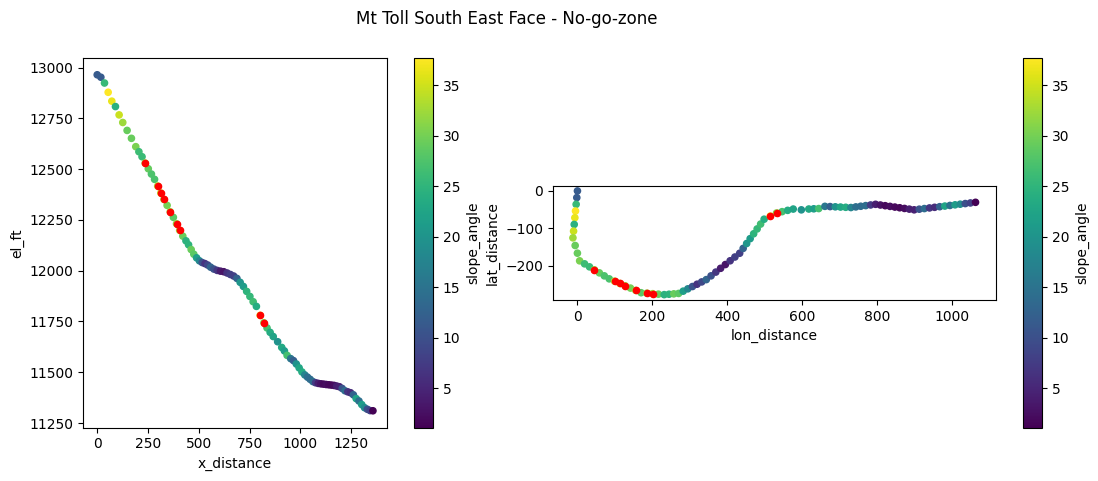

In [13]:
#### No Go Zone
title = 'Mt Toll South East Face'
df = df_dict[title]
filtered_df = nogo_filter(df_dict[title], hazard_zone, max_slope)

fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_figwidth(15)
plt.subplots_adjust(wspace=0.1)
fig.suptitle(f'{title} - No-go-zone')
df.plot.scatter(x = 'x_distance',y = 'el_ft', c = 'slope_angle', ax = ax1)
filtered_df.plot.scatter(x = 'x_distance',y = 'el_ft', c = 'red', ax = ax1)


df.plot.scatter(x = 'lon_distance',y = 'lat_distance', c = 'slope_angle', ax = ax2)
filtered_df.plot.scatter(x = 'lon_distance',y = 'lat_distance', c = 'red', ax = ax2)
ax2.set_aspect('equal')
ax1.set_aspect('equal')

In [36]:
import plotly.graph_objects as go
import numpy as np


layout = go.Layout(scene=dict(aspectmode='data'),
                   title= title,
                   showlegend=False)

fig = go.Figure(layout=layout, data=[go.Scatter3d(x=df['lon_distance'],y=df['lat_distance'],z=df['el'],
                                                  mode='markers',marker=dict(size=5,color=df['slope_angle'],colorscale='Viridis', opacity=0.8)),
                                     go.Scatter3d(x=filtered_df['lon_distance'],y=filtered_df['lat_distance'],z=filtered_df['el'],
                                                  mode='markers',marker=dict(size=5,color='red',colorscale='Viridis', opacity=0.8))
                                     ])

camera = dict(
    up=dict(x=0, y=1., z=0),
    eye=dict(x=0, y=0, z=2)
)

fig.update_layout(scene_camera=camera)

# fig.update_layout(eye=dict(x=1.5, y=1.5, z=1.5))
fig.show()

In [15]:
cardinal_df = pd.DataFrame(columns = ['cardinal','count'])
for direction in aspect_dict.keys():
    count = df_dict['Audobahn Cradle']['cardinal'].value_counts().get(direction,0)
    cardinal_df.loc[len(cardinal_df)] = [direction,count]
cardinal_df

,cardinal,count
0,N,0
1,NNE,0
2,NE,7
3,ENE,10
4,E,24
5,ESE,19
6,SE,0
7,SSE,8
8,S,15
9,SSW,13


In [27]:
df_dict_dir = Path('df_dict')
df_dict_dir.mkdir(parents=True, exist_ok = True)
for title,df in df_dict.items():
    if '?' in title:
        print('BAD:',title)
        title = title.replace("?",'')
        print('New:',title)
    print(f'Saving {title}')
    df.to_csv(df_dict_dir/f'{title}.csv')

Saving 
Saving AIARE Day 2 Line
Saving Aspen
Saving Audobahn Cradle
Saving Baldys Skirt
Saving Banana Bowl
Saving Battle Bushes
Saving Battle Shoulder
Saving Beacon S Face
Saving Caribou Glades
Saving Caribou Hill
Saving Caribou Trees
Saving Curvaceous Couloir
Saving Dragontail Apron
Saving Dream Chute 1
Saving Dream Chute 2
Saving Easy Alley
Saving Flattop north face
Saving Frost Mountain Ascent
Saving Grays east face
Saving Haiyaha Shortcut
Saving Joe Mills
Saving LP N. Shorty
Saving Lefthand Glades
Saving Little Pawnee Ascent
Saving Little Pawnee East Buttress
Saving Little Pawnee East Shoulder
Saving Little Pawnee South Shoulder
Saving Long Lake Meadows
Saving Mario Gully
Saving McMillan West Ridge
Saving Meadow Mountain
Saving Meeker Shoulder
Saving Mooswa 
Saving Mt Toll South East Face
Saving Mt Wuh
BAD: Niwot Mystery Road?
New: Niwot Mystery Road
Saving Niwot Mystery Road
Saving Niwot Ramp
Saving Otis Chute
Saving Paiute South Slope
Saving Pawnee SE Slope
Saving Pawshoni Bowl
S

In [35]:
df_import_dict = {}
for file in df_dict_dir.iterdir():
    title = file.stem
    df_import_dict[title] = pd.read_csv(file)

df_import_dict['Audobahn Cradle']

,Unnamed: 0,lat_distance,lon_distance,x_distance,el,slope_angle,aspect,cardinal,aspect_x,aspect_y,el_ft,drop,tree_cover
0,0,0.000000,0.000000,0.000000,3541.202393,1.336445,78.902508,ENE,0.192479,0.981301,11618.118458,NaN,NTL
1,1,2.354673,12.004652,12.233403,3540.916992,1.336445,78.902508,ENE,0.192479,0.981301,11617.182105,-0.936353,NTL
2,2,4.709345,24.009298,24.466800,3540.153076,3.573202,78.902508,ENE,0.192479,0.981301,11614.675818,-2.506286,NTL
3,3,7.064016,36.013937,36.700191,3538.919434,5.758368,78.902508,ENE,0.192479,0.981301,11610.628435,-4.047384,NTL
4,4,9.418686,48.018569,48.933574,3536.748535,10.062776,78.902508,ENE,0.192479,0.981301,11603.506064,-7.122370,NTL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,91,-585.055990,538.564438,1222.866397,3289.000244,20.847400,168.658200,SSE,-0.980471,0.196661,10790.683561,-18.842402,BTL
92,92,-599.842850,541.530364,1237.947774,3283.681396,19.426550,168.658200,SSE,-0.980471,0.196661,10773.233273,-17.450288,BTL
93,93,-614.629696,544.496288,1253.029137,3277.197266,23.264962,168.658200,SSE,-0.980471,0.196661,10751.959877,-21.273396,BTL
94,94,-629.416526,547.462208,1268.110484,3269.503906,27.027227,168.658200,SSE,-0.980471,0.196661,10726.719196,-25.240681,BTL


In [1]:
summary_df

NameError: name 'summary_df' is not defined